## Advanced Classification


# Import Libraries

In [5]:
%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from itertools import cycle
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import tree
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder

#from scikitplot.metrics import plot_roc

# Prep Data

In [6]:
#df = pd.read_csv(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\df_SenzaOutlier.csv') 
df = pd.read_csv(r'Data/Processed/final_df_standard_scaler_box_cox.csv') 
df.shape

(88554, 24)

In [7]:
categoriche_da_trasformare = [ 'explicit', 'genre']

# Applica il LabelEncoder a ciascuna colonna categorica
label_encoder = LabelEncoder()
for col in categoriche_da_trasformare:
    df[col] = label_encoder.fit_transform(df[col])



In [8]:
df = df.drop(columns=['Unnamed: 0', 'valence', 'energy'])

In [9]:

# Inizializza il LabelEncoder
label_encoder = LabelEncoder()

# Codifica le etichette di emozione nel DataFrame
df['mood'] = label_encoder.fit_transform(df['mood'])
df

,duration_ms,popularity,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,tempo_confidence,...,key_confidence,mode_confidence,popularity_artist,followers_artist,explicit,key,mode,time_signature,genre,mood
0,-0.680781,0.162759,1.978201,-0.275068,0.999975,-0.740877,-0.522897,-0.321113,-0.618882,0.433548,...,0.786251,0.398323,-0.188934,-0.304401,1,8,0,4,39,3
1,0.940114,0.812539,-1.691805,0.208828,-0.452776,0.240034,-0.532243,-0.511836,1.878636,-1.384628,...,0.895193,1.134200,1.049266,-0.103532,0,0,1,4,17,0
2,2.862979,-1.461689,0.695703,-0.941570,-0.366899,-0.962302,0.029763,-0.542764,-0.081356,1.276279,...,-1.767842,-1.034990,0.092476,-0.222466,0,5,0,4,73,0
3,-0.386216,1.415905,0.655625,0.954063,0.919465,-0.792551,-0.532243,-0.689672,1.324332,-1.142426,...,-0.609825,-0.205755,0.458307,-0.119712,0,0,1,4,51,1
4,1.023124,-0.533433,-0.260445,-1.008220,-0.519867,-0.962825,1.703361,-0.642765,0.254670,0.579533,...,-1.933273,-1.924633,0.767857,-0.149780,0,6,0,4,73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88549,0.962328,1.508731,1.153738,-0.590779,-0.490347,1.107203,-0.527803,-0.305649,-0.081524,0.957767,...,0.055934,0.200625,0.852280,-0.113375,0,7,0,4,81,2
88550,-1.191927,-0.022892,-0.203191,-4.644748,-0.255080,1.992191,2.445458,-0.642765,-1.338099,-0.800688,...,1.504464,2.688329,-1.033161,-0.306613,0,10,1,4,26,2
88551,0.316970,1.508731,-0.810087,-0.199843,-0.447409,1.196296,-0.532243,-0.573692,0.275053,-0.588346,...,-0.383871,0.123742,0.824139,-0.130130,0,3,1,4,70,3
88552,0.054432,1.323080,0.483862,-0.584153,-0.425045,-0.169793,2.361622,-0.612868,0.087331,1.694327,...,0.011550,-1.523744,0.205039,-0.301417,0,10,0,4,32,0


In [10]:

# Costruisci il mapping
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Stampa il mapping
print("Mapping delle emozioni:")
for emotion, code in mapping.items():
    print(f"{emotion}: {code}")

# Decodifica un esempio
decoded_code = 1  # Esempio di codice da decodificare
decoded_emotion = label_encoder.inverse_transform([decoded_code])[0]
print(f"\nDecodificato il codice {decoded_code}: {decoded_emotion}")


Mapping delle emozioni:
Angry: 0
Happy: 1
Relaxed: 2
Sad: 3

Decodificato il codice 1: Happy


In [11]:
mapping

{'Angry': 0, 'Happy': 1, 'Relaxed': 2, 'Sad': 3}

In [12]:
df['mood'].value_counts()

mood
1    32908
0    29932
3    18518
2     7196
Name: count, dtype: int64

# Split

In [13]:
attributes = [col for col in df.columns if col != "mood"]

X = df[attributes].values
y = np.array(df["mood"])  # oppure y = df['emotion].values

X.shape, y.shape

((88554, 20), (88554,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Usando l'opzione stratify=y, garantisci che la suddivisione mantenga la stessa proporzione di classi tra set di addestramento e di test, utile quando hai un set di dati sbilanciato

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70843, 20), (17711, 20), (70843,), (17711,))

## LOGISTIC REGRESSION

- posso usarla per multiclasse?\
Sì, la regressione logistica può essere estesa per gestire problemi di classificazione multiclasse. La versione standard della regressione logistica è comunemente utilizzata per problemi di classificazione binaria, ma esistono approcci per adattarla ai casi con più di due classi. Due degli approcci più comuni sono l'uno-contro-tutti (one-vs-all) e l'uno-contro-uno (one-vs-one).


In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’.



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [19]:
#logistic regression senza paramatri

# DEFAULT C=1.0, penalty='l2', solver='lbfgs'
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Accuracy 0.6368358647168426
F1-score 0.6278641193338226
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      5986
           1       0.62      0.69      0.65      6582
           2       0.53      0.22      0.31      1439
           3       0.69      0.75      0.72      3704

    accuracy                           0.64     17711
   macro avg       0.62      0.57      0.58     17711
weighted avg       0.63      0.64      0.63     17711



/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# GRID SEARCH

In [20]:
#1 - 'ovr'

#run in 3 min

model = LogisticRegression(random_state=42) 

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'multi_class': ['ovr']
}

random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Esegui la ricerca casuale sulla griglia sul training set
random_search.fit(X_train, y_train)

# Visualizza i parametri ottimizzati
print("Migliori parametri:", random_search.best_params_)
print("Miglior score: ", random_search.best_score_)

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticReg

Migliori parametri: {'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'C': 10}
Miglior score:  0.6477421930452429


In [21]:
lr1 = random_search.best_estimator_
lr1.fit(X_train, y_train)

y_pred = lr1.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=mapping)) 

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy 0.6379086443453221
F1-score 0.6209693261623356
              precision    recall  f1-score   support

       Angry       0.64      0.61      0.63      5986
       Happy       0.61      0.71      0.65      6582
     Relaxed       0.61      0.10      0.18      1439
         Sad       0.69      0.76      0.72      3704

    accuracy                           0.64     17711
   macro avg       0.64      0.55      0.55     17711
weighted avg       0.64      0.64      0.62     17711



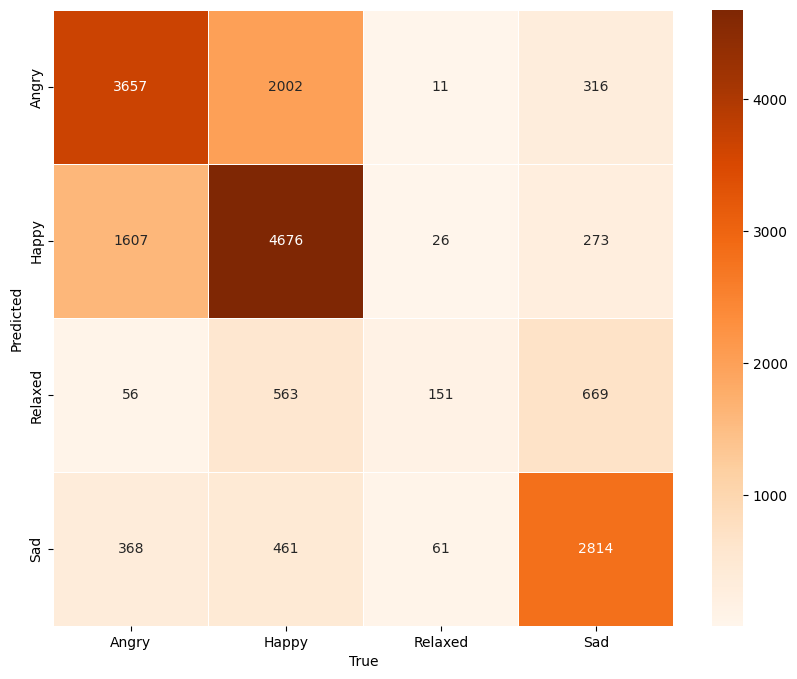

0.8581957821917516


In [22]:
cm = confusion_matrix(y_test, y_pred)
# Plot della matrice di confusione
plt.figure(figsize=(10, 8))  # Imposta le dimensioni del plot
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=mapping, yticklabels=mapping, linewidths=0.5) 
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# ROC CURVE, anche se linearSVM non ha la predict_proba
y_pred_proba = lr1.predict_proba(X_test)
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#plot_roc(y_test, lr1.predict_proba(X_test), )
plt.show()
print(roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro"))

# plot della PRECISION-RECALL
#plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

In [23]:
#2 - 'multinomial'

#run in 8

model = LogisticRegression(random_state=42) 

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'multi_class': ['multinomial']
}

random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)

# Esegui la ricerca casuale sulla griglia sul training set
random_search.fit(X_train, y_train)

# Visualizza i parametri ottimizzati
print("Migliori parametri:", random_search.best_params_)
print("Miglior score: ", random_search.best_score_)

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave

Migliori parametri: {'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 0.01}
Miglior score:  0.6519204150877094


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
lr2 = random_search.best_estimator_
lr2.fit(X_train, y_train)

# Valutazione delle performance sul set di test
y_pred = lr2.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=mapping)) 

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy 0.6434419287448478
F1-score 0.6370093132840515
              precision    recall  f1-score   support

       Angry       0.65      0.61      0.63      5986
       Happy       0.62      0.70      0.66      6582
     Relaxed       0.54      0.28      0.37      1439
         Sad       0.70      0.75      0.72      3704

    accuracy                           0.64     17711
   macro avg       0.63      0.58      0.59     17711
weighted avg       0.64      0.64      0.64     17711



/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


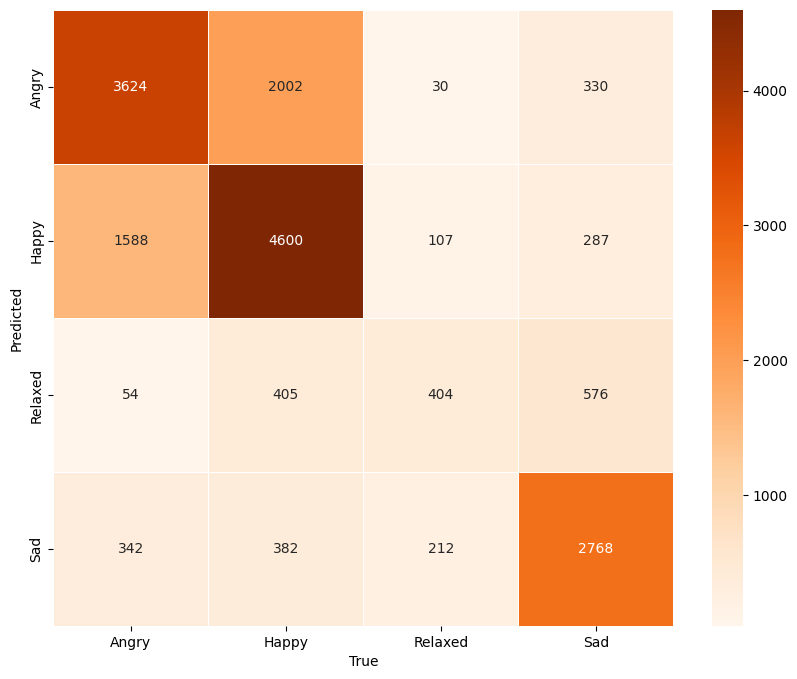

0.8678369283807446


In [25]:
# confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))  # Imposta le dimensioni del plot
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=mapping, yticklabels=mapping, linewidths=0.5) 
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


# ROC CURVE, anche se linearSVM non ha la predict_proba
y_pred_proba = lr2.predict_proba(X_test)
#plot_roc(y_test, lr2.predict_proba(X_test), )
plt.show()
print(roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro"))


# plot della PRECISION-RECALL
#plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

# SVM

Trova il miglior iperpiano lineare oppure non-lineare che meglio separa i dati delle diverse classi 

Iperpiano che massimizza i margini è il migliore, non troppo vicino ai dati perchè se aggiungo nuove istanze potrebbe sbagliare, devo trovare iperpiano che è più utile nel fare questa separazione

#### Linear SVM

I modelli 'Linear SVM' utilizzano un iperpiano lineare per separare i dati

- parametro C: assunto nei seguenti valori 0.01, 0.1, 1.0, 10.0, 100.0, è un parametro di regolarizazione sul livello di misclassification error che il può avere il modello 

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [27]:
# CASO BASE DI LINEAR SVM C=1.0, penalty=L2

clf = LinearSVC(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))

print(classification_report(y_test, y_pred, target_names=mapping))


Accuracy 0.6337869120885326
F1-score 0.6085989245257862
              precision    recall  f1-score   support

       Angry       0.65      0.61      0.63      5986
       Happy       0.60      0.71      0.65      6582
     Relaxed       0.48      0.02      0.04      1439
         Sad       0.67      0.77      0.72      3704

    accuracy                           0.63     17711
   macro avg       0.60      0.53      0.51     17711
weighted avg       0.62      0.63      0.61     17711



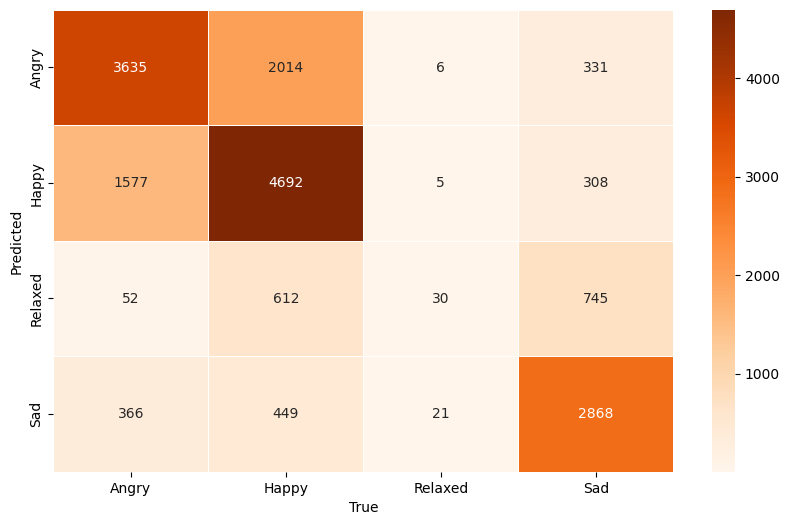

In [30]:

# plot della CONFUSION MATRIX 
cf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))  # Imposta le dimensioni del plot
sns.heatmap(cf, annot=True, fmt='d', cmap="Oranges", xticklabels=mapping, yticklabels=mapping, linewidths=0.5)

plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

#### Random Search per tuning dei parametri migliori 
- penalty
- parametro C
 

In [31]:
#run in 13

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Crea un oggetto LinearSVC
svc = LinearSVC(random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'tol': loguniform(1e-6, 1e-2)  # esplora valori di tolleranza tra 1e-6 e 1e-2
}

# Crea un oggetto GridSearchCV con cross-validation a 5 suddivisioni
#grid_search = GridSearchCV(svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search = RandomizedSearchCV(svc, param_distributions=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# Esegui la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Stampa i risultati
print("Migliori parametri: ", grid_search.best_params_)
print("Miglior score: ", grid_search.best_score_)

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_M

Migliori parametri:  {'C': 0.1, 'penalty': 'l1', 'tol': np.float64(0.0004379488879893927)}
Miglior score:  0.6429569344389512


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### applico i migliori risultati ottenuti 

In [32]:
# VALORI DI SVM MIGLIORI C=1, penalty=L2

clf = grid_search.best_estimator_
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))

print(classification_report(y_test, y_pred, target_names=mapping))


Accuracy 0.6334481395742759
F1-score 0.608207081815576
              precision    recall  f1-score   support

       Angry       0.65      0.61      0.63      5986
       Happy       0.60      0.71      0.65      6582
     Relaxed       0.48      0.02      0.04      1439
         Sad       0.68      0.77      0.72      3704

    accuracy                           0.63     17711
   macro avg       0.60      0.53      0.51     17711
weighted avg       0.62      0.63      0.61     17711



/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
#Calcola l'accuratezza e altre metriche di valutazione del modello sia sui dati di addestramento che sui dati di test.

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza sul set di addestramento:", train_accuracy)
print("Accuratezza sul set di test:", test_accuracy)

Accuratezza sul set di addestramento: 0.6434368956707085
Accuratezza sul set di test: 0.6334481395742759


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_M

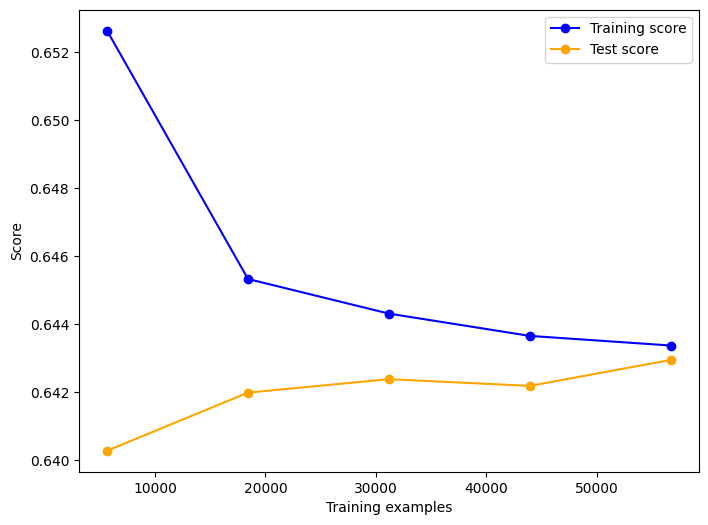

In [34]:
# Disegna le curve di apprendimento per valutare le prestazioni del modello al variare della dimensione 
# del set di addestramento e confronta le prestazioni sul set di addestramento e di test.


plt.figure(figsize=(8, 6))  # Modifica le dimensioni come desiderato (larghezza, altezza)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score', color = 'blue')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Test score', color= 'orange')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


grafici, ROC curve, precision-recall curve

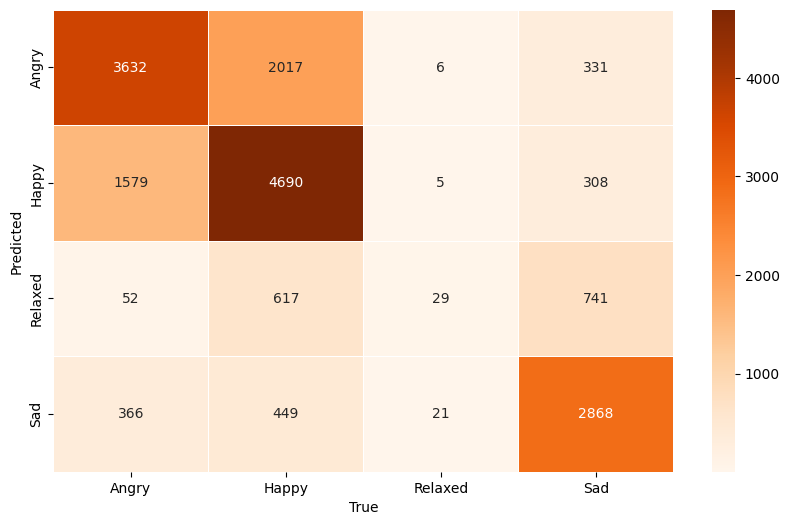

In [36]:
# plot della CONFUSION MATRIX 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))  # Imposta le dimensioni del plot
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=mapping, yticklabels=mapping, linewidths=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


# Nonlinear SVM


In [37]:
from sklearn.svm import SVC

### Caso base, c=1.0 e kernel='rbf', gamma=scale

Il parametro `probability` nella classe `SVC` di scikit-learn indica se il classificatore deve abilitare il calcolo delle probabilità di appartenenza delle osservazioni a ciascuna classe. Di default, questo parametro è impostato su `False`, il che significa che il classificatore SVM non calcola le probabilità delle previsioni.

Quando `probability=True`, il classificatore SVM addestrato calcolerà le probabilità di appartenenza alle classi utilizzando una funzione di calibrazione delle probabilità. Questo è utile se hai bisogno di valutare la confidenza delle previsioni o se desideri utilizzare il classificatore SVM come parte di un insieme di modelli in un contesto di classificazione probabilistica.

Puoi utilizzare le probabilità calcolate per valutare la fiducia del classificatore nelle sue previsioni o per applicazioni come la curva di ROC (Receiver Operating Characteristic) o la curva di precision-recall.

Ad esempio, se desideri calcolare le probabilità delle previsioni con un classificatore SVM abilitato per le probabilità, puoi farlo usando il metodo `predict_proba()`. Tuttavia, tieni presente che abilitare il calcolo delle probabilità può richiedere più risorse computazionali durante l'addestramento e l'uso del modello.

In [38]:
#ci ha messo 67 minuti

clf = SVC(random_state=42)  #, probability=True
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=mapping))


Accuracy 0.6393766585737677
F1-score [0.62789265 0.66996812 0.03376097 0.71295469]
              precision    recall  f1-score   support

       Angry       0.66      0.60      0.63      5986
       Happy       0.61      0.75      0.67      6582
     Relaxed       0.60      0.02      0.03      1439
         Sad       0.68      0.75      0.71      3704

    accuracy                           0.64     17711
   macro avg       0.63      0.53      0.51     17711
weighted avg       0.64      0.64      0.61     17711



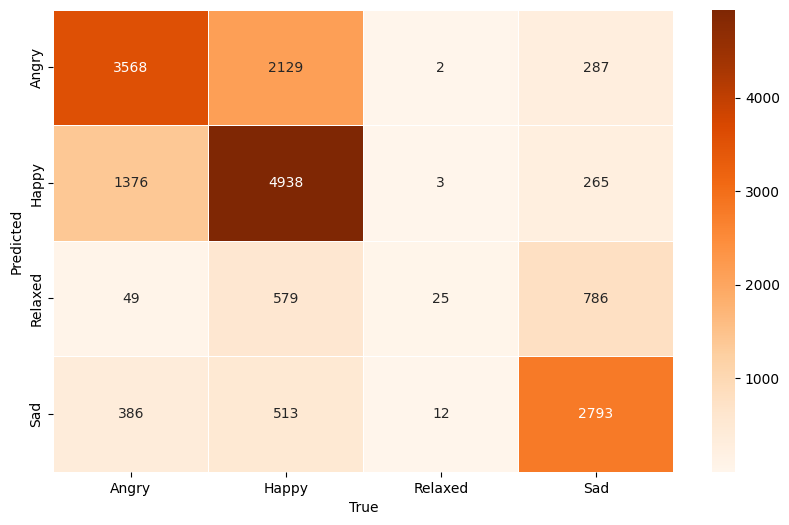

In [39]:


# plot della CONFUSION MATRIX 
cf3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))  # Imposta le dimensioni del plot
sns.heatmap(cf3, annot=True, fmt='d', cmap="Oranges", xticklabels=mapping, yticklabels=mapping, linewidths=0.5)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

prova bilanciamento su linear

In [2]:
#Prova bilanciamento
from imblearn.combine import SMOTEENN, SMOTETomek

In [15]:
df['mood'].value_counts()

mood
1    32908
0    29932
3    18518
2     7196
Name: count, dtype: int64

In [16]:
# Utilizza SMOTETomek per bilanciare le classi

smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({np.int64(2): 26291, np.int64(3): 25983, np.int64(1): 24227, np.int64(0): 24157})


In [19]:
#run in 39

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Crea un oggetto LinearSVC
svc = LinearSVC(random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'tol': loguniform(1e-6, 1e-2)  # esplora valori di tolleranza tra 1e-6 e 1e-2
}

grid_search = RandomizedSearchCV(svc, param_distributions=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_res, y_res)

print("Migliori parametri: ", grid_search.best_params_)
print("Miglior score: ", grid_search.best_score_)

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/daviderizzello/Documents/UNIPI/Data_M

Migliori parametri:  {'C': 0.1, 'penalty': 'l2', 'tol': np.float64(0.00042756600294589564)}
Miglior score:  0.6524470199035972


#### applico i migliori risultati ottenuti 

In [22]:
clf_bal = grid_search.best_estimator_
clf_bal.fit(X_res, y_res)


y_pred = clf_bal.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))

print(classification_report(y_test, y_pred, target_names=mapping))


Accuracy 0.6084354356049912
F1-score 0.6160302717584267
              precision    recall  f1-score   support

       Angry       0.64      0.63      0.64      5986
       Happy       0.67      0.55      0.60      6582
     Relaxed       0.33      0.67      0.44      1439
         Sad       0.71      0.65      0.68      3704

    accuracy                           0.61     17711
   macro avg       0.58      0.62      0.59     17711
weighted avg       0.64      0.61      0.62     17711



In [23]:
#Calcola l'accuratezza e altre metriche di valutazione del modello sia sui dati di addestramento che sui dati di test.

train_accuracy = accuracy_score(y_res, clf_bal.predict(X_res))
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuratezza sul set di addestramento:", train_accuracy)
print("Accuratezza sul set di test:", test_accuracy)

Accuratezza sul set di addestramento: 0.6529933040592899
Accuratezza sul set di test: 0.6084354356049912
